# Positional Validation


In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl

ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

## Read the Data


In [2]:
veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    .sort(
        "gps_time",
    )
    # .upsample(
    #     "gps_time",
    #     every="100ms",
    # )
    # .sort("gps_time")
    # .with_columns(
    #     pl.col(pl.FLOAT_DTYPES).interpolate(),
    #     pl.col(pl.INTEGER_DTYPES).first(),
    # )
    .with_row_count(name="seq")
)

In [3]:
veh_df.shape

(19612, 5)

### Map to Lanes


In [4]:
import geopandas as gpd
from src.geometry import RoadNetwork


network = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
)

lane_df = network.df

## Snap the Vehicle Trajectories to Lanes


In [5]:
import utm

x, y, _, _ = utm.from_latlon(
    latitude=veh_df["lat"].to_numpy(),
    longitude=veh_df["lon"].to_numpy(),
)

veh_df = (
    veh_df.with_columns(
        x=x,
        y=y,
    )
    .with_columns(
        (pl.col("x").diff() ** 2 + pl.col("y").diff() ** 2).sqrt().alias("dist"),
    )
    .with_columns(
        (
            pl.col("dist") / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("speed"),
    )
)

veh_df.head()

shape: (5, 9)
┌─────┬───────────────┬───────────┬────────────┬───┬──────────────┬──────────┬──────────┬──────────┐
│ seq ┆ gps_time      ┆ lat       ┆ lon        ┆ … ┆ x            ┆ y        ┆ dist     ┆ speed    │
│ --- ┆ ---           ┆ ---       ┆ ---        ┆   ┆ ---          ┆ ---      ┆ ---      ┆ ---      │
│ u32 ┆ datetime[μs,  ┆ f64       ┆ f64        ┆   ┆ f64          ┆ f64      ┆ f64      ┆ f64      │
│     ┆ UTC]          ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
╞═════╪═══════════════╪═══════════╪════════════╪═══╪══════════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97831 ┆ 3.6775e6 ┆ null     ┆ null     │
│     ┆ 16:43:11.400  ┆           ┆            ┆   ┆ 5            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 1   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97869 ┆ 3.6775e6 ┆ 0.000962 ┆ 0.009621 │
│     ┆ 16:43:11.500  ┆           ┆            ┆   ┆ 2            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 2   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97924 ┆ 3.6775e6 ┆ 0.000787 ┆ 0.007873 │
│     ┆ 16:43:11.600  ┆           ┆            ┆   ┆ 8            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 3   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97850 ┆ 3.6775e6 ┆ 0.000816 ┆ 0.008162 │
│     ┆ 16:43:11.700  ┆           ┆            ┆   ┆ 1            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 4   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97897 ┆ 3.6775e6 ┆ 0.000724 ┆ 0.007241 │
│     ┆ 16:43:11.800  ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
└─────┴───────────────┴───────────┴────────────┴───┴──────────────┴──────────┴──────────┴──────────┘

### Build the KDTree


In [6]:
veh_df = network.map_to_lane(
    veh_df,
    dist_upper_bound=3,
    utm_x_col="x",
    utm_y_col="y",
)

In [7]:
veh_df = (
    veh_df.with_columns(
        pl.col("name").fill_null(""),
    )
    .with_columns(
        (
            (pl.col("name").shift(1) != pl.col("name"))
            & (pl.col("name").shift(1) != "")
        ).alias("sequence"),
    )
    .with_columns(
        (pl.col("sequence").cum_sum() * (pl.col("name") != "")).alias("sequence_id"),
    )
    .filter(pl.col("sequence_id") != 0)
)

In [8]:
veh_df.head()

shape: (5, 18)
┌──────┬────────────────────┬───────────┬────────────┬───┬─────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time           ┆ lat       ┆ lon        ┆ … ┆ angle   ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---                ┆ ---       ┆ ---        ┆   ┆ ---     ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs, UTC]  ┆ f64       ┆ f64        ┆   ┆ f64     ┆ str  ┆ bool     ┆ u32         │
╞══════╪════════════════════╪═══════════╪════════════╪═══╪═════════╪══════╪══════════╪═════════════╡
│ 1325 ┆ 2023-10-31         ┆ 33.235712 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ true     ┆ 1           │
│      ┆ 16:45:35.200 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1326 ┆ 2023-10-31         ┆ 33.235719 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.300 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1327 ┆ 2023-10-31         ┆ 33.235726 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.400 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1328 ┆ 2023-10-31         ┆ 33.235734 ┆ -87.610402 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.500 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1329 ┆ 2023-10-31         ┆ 33.235741 ┆ -87.610402 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.600 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
└──────┴────────────────────┴───────────┴────────────┴───┴─────────┴──────┴──────────┴─────────────┘

In [9]:
ebl1_df = veh_df.filter(pl.col("sequence_id") == 12).with_columns(
    (
        pl.col("s").diff() / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
    ).alias("speed")
)

In [10]:
ebl1_df.head()

shape: (5, 18)
┌──────┬──────────────────┬───────────┬────────────┬───┬───────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time         ┆ lat       ┆ lon        ┆ … ┆ angle     ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---              ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs,     ┆ f64       ┆ f64        ┆   ┆ f64       ┆ str  ┆ bool     ┆ u32         │
│      ┆ UTC]             ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
╞══════╪══════════════════╪═══════════╪════════════╪═══╪═══════════╪══════╪══════════╪═════════════╡
│ 8562 ┆ 2023-10-31       ┆ 33.234887 ┆ -87.614469 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.600 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8563 ┆ 2023-10-31       ┆ 33.234893 ┆ -87.614466 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.700 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8564 ┆ 2023-10-31       ┆ 33.234898 ┆ -87.614463 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.800 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8565 ┆ 2023-10-31       ┆ 33.234903 ┆ -87.614461 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.900 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8566 ┆ 2023-10-31       ┆ 33.234908 ┆ -87.614459 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:47 UTC     ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
└──────┴──────────────────┴───────────┴────────────┴───┴───────────┴──────┴──────────┴─────────────┘

## Read in the Trajectories


In [11]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


# make a consolidated network with only EBL1 and WBL1

mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
)

radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


radar_df = (
    pl.scan_parquet(
        ROOT.joinpath("data", "raw", "*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(seconds=30),
            pl.col("gps_time").max() + timedelta(seconds=30),
        )
    )
    # .filter(pl.col("ip").str.split(".").list.last().is_in(["146", "147", "142"]))
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    # .filter(pl.col("ip").str.contains("146")
    # .collect()
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=10,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .rename({"name": "lane"})
)

function: create_object_id took: 0.0010142326354980469 seconds
function: filter_short_trajectories took: 0.0013091564178466797 seconds
function: clip_trajectory_end took: 0.00030994415283203125 seconds
function: resample took: 0.00036406517028808594 seconds
function: fix_duplicate_positions took: 9.918212890625e-05 seconds
function: set_timezone took: 3.600120544433594e-05 seconds
function: add_cst_timezone took: 1.811981201171875e-05 seconds
function: add_heading took: 2.4080276489257812e-05 seconds
function: rotate_radars took: 0.0003325939178466797 seconds
function: update_origin took: 0.00012087821960449219 seconds


In [12]:
# radar_df.filter(
#     pl.col('object_id') == 3631321283062933221
# )

In [13]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)

radar_df = (
    radar_df.rename(
        {
            "angle": "heading_lane",
        }
    )
    .pipe(filter_short_trajectories, minimum_distance_m=10, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension)
    .pipe(add_timedelta)
    .pipe(build_kalman_id)
    .collect()
)

function: filter_short_trajectories took: 0.03802800178527832 seconds
function: prepare_frenet_measurement took: 0.0002880096435546875 seconds
function: build_extension took: 0.5668070316314697 seconds
function: add_timedelta took: 6.580352783203125e-05 seconds
function: build_kalman_id took: 0.00014591217041015625 seconds


In [14]:
radar_df.filter(
    (pl.col("epoch_time") - pl.col("epoch_time").min()).dt.total_minutes() < 2
).pipe(
    radar_obj.radar_to_latlon,
    utm_x_col="x_lane",
    utm_y_col="y_lane",
    lat_col="lat_lane",
    lon_col="lon_lane",
).select(
    ["object_id", "epoch_time", "lat", "lon", "lat_lane", "lon_lane", "ip"]
).write_csv(ROOT / "data" / "radar_lane.csv")

function: radar_to_latlon took: 0.011873960494995117 seconds


In [15]:
radar_df[["s", "s_velocity", "d", "d_velocity"]].describe()

shape: (9, 5)
┌────────────┬─────────────┬────────────┬───────────┬────────────┐
│ describe   ┆ s           ┆ s_velocity ┆ d         ┆ d_velocity │
│ ---        ┆ ---         ┆ ---        ┆ ---       ┆ ---        │
│ str        ┆ f64         ┆ f64        ┆ f64       ┆ f64        │
╞════════════╪═════════════╪════════════╪═══════════╪════════════╡
│ count      ┆ 1.12764e6   ┆ 1.12764e6  ┆ 1.12764e6 ┆ 1.12764e6  │
│ null_count ┆ 0.0         ┆ 0.0        ┆ 0.0       ┆ 0.0        │
│ mean       ┆ 864.273628  ┆ 13.99848   ┆ 1.536991  ┆ -0.140127  │
│ std        ┆ 335.258513  ┆ 7.580779   ┆ 3.528379  ┆ 0.654485   │
│ min        ┆ 20.700023   ┆ 0.0        ┆ -9.997848 ┆ -7.586312  │
│ 25%        ┆ 573.900636  ┆ 8.391951   ┆ -0.35244  ┆ -0.344419  │
│ 50%        ┆ 843.194008  ┆ 15.519548  ┆ 1.017813  ┆ -0.045137  │
│ 75%        ┆ 1165.501293 ┆ 19.942905  ┆ 3.844543  ┆ 0.137446   │
│ max        ┆ 1693.401878 ┆ 34.049948  ┆ 9.999982  ┆ 5.606703   │
└────────────┴─────────────┴────────────┴───────────┴────────────┘

In [16]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = radar_df.pipe(build_kalman_df).collect()

function: build_kalman_df took: 0.0003209114074707031 seconds


### Loop through all the Trajectories and find the Trouble Ones


In [17]:
# from src.filters.vectorized_kalman import IMMFilter, CALCFilter, CVLKFilter
# import numpy as np


# for vehicle_id in filter_df["vehicle_ind"].unique():
#     veh_df = filter_df.filter(pl.col("vehicle_ind") == vehicle_id).with_columns(
#         pl.lit(0).alias("vehicle_ind")
#     )

#     IMMFilter(
#         df=veh_df.rename({"measurement": "z"}),
#         filters=("CALC", "CALK", "CVLK"),
#         M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
#         mu=np.array([0.05, 0.3, 0.65]),
#         gpu=False,
#     ).apply_filter()

In [18]:
# radar_df.filter(pl.col("kalman_id") == veh_df["kalman_id"][0])

### IMM Filter the Radar Trajectories


In [19]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    mu=np.array([0.05, 0.3, 0.65]),
    # chunk_size=3_500,
    chunk_size=800,
    gpu=False,
)

100%|██████████| 9/9 [00:47<00:00,  5.26s/it]


In [20]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df).collect()

function: join_results took: 0.0033233165740966797 seconds


## Plotting the Lanes


<Axes: ylabel='Frequency'>

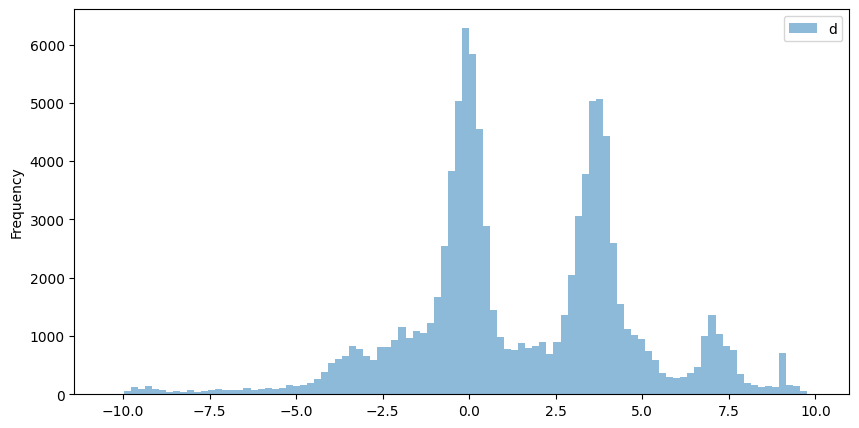

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("W"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

<Axes: ylabel='Frequency'>

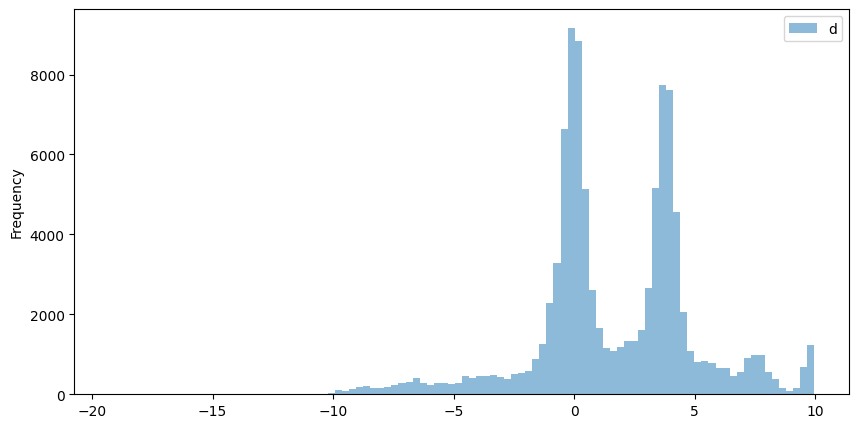

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("E"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

### Classify the Lanes


In [23]:
from src.pipelines.lane_classification import label_lane
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [24]:
joined_df = joined_df.pipe(label_lane, right_lane_center=0, lane_width=3.55)

function: label_lane took: 0.03810405731201172 seconds


In [25]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 5))

# laned_df.filter(pl.col("lane").str.contains("W") & pl.col('lane_index').is_not_null())[["d"]].sample(
#     100_000
# ).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5, )

# # set the range of the x-axis to be the same
# # ax.set_xlim(-6, 10)
# # radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

In [26]:
# eblm = build_lane_model(
#     lane_centers=[-3.5, 0, 3.5, 7],
#     train_data=joined_df.filter(
#         (pl.col("lane").str.contains("E"))
#         # & pl.col("d").is_between(-10, 10)
#         & ~pl.col('prediction')
#     )[["d"]],
#     priors=[0.05, 0.45, 0.45, 0.05],
#     variance=0.1,
# )

# fig, ax = plt.subplots(figsize=(10, 5))

# plot_model(
#     eblm,
#     ax=ax,
#     range=(-5, 8),
#     lane_names=["EBL1", "EBL2", "EBL3", "EBL4"],
# )

## Merge the Trajectories


In [27]:
from src.pipelines.association import build_leader_follower_df, add_front_back_s

lf_df = (
    joined_df.lazy()
    .pipe(add_front_back_s, use_median_length=False)
    .pipe(build_leader_follower_df)
    # only consider vehicles that are fairly close
    .filter(pl.col("s_gap") < 10)
    # don't keep matches that are both prediction
    .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    # .filter()
    # assumption that radar tracks perfectly
    # .filter(pl.col("ip") != pl.col("ip_leader"))
    .filter(pl.col("s_velocity") > 5)
    .collect()
)

function: add_front_back_s took: 0.0007557868957519531 seconds
function: lazy_func took: 0.002579927444458008 seconds


In [28]:
lf_df.head()

shape: (5, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ object_id ┆ epoch_tim ┆ lane_hash ┆ leader    ┆ … ┆ P_leader  ┆ predictio ┆ ip_leader ┆ s_gap    │
│ ---       ┆ e         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ n_leader  ┆ ---       ┆ ---      │
│ u64       ┆ ---       ┆ u64       ┆ u64       ┆   ┆ array[f32 ┆ ---       ┆ str       ┆ f32      │
│           ┆ datetime[ ┆           ┆           ┆   ┆ , 36]     ┆ bool      ┆           ┆          │
│           ┆ ms, UTC]  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [2.857142 ┆ false     ┆ 10.160.7. ┆ 4.100098 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ , 0.0, …  ┆           ┆ 137       ┆          │
│ 7         ┆ 5.300 UTC ┆ 71        ┆ 1         ┆   ┆ 9.999999] ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.668286 ┆ false     ┆ 10.160.7. ┆ 3.940674 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.400 UTC ┆ 71        ┆ 1         ┆   ┆ 0.02779,  ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 0.935181] ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.180505 ┆ false     ┆ 10.160.7. ┆ 4.059814 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.500 UTC ┆ 71        ┆ 1         ┆   ┆ 0.036634, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 0.65079]  ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [2.857143 ┆ false     ┆ 10.160.7. ┆ 8.498596 │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ , 0.0, …  ┆           ┆ 146       ┆          │
│ 68        ┆ 5.600 UTC ┆ 17        ┆ 4         ┆   ┆ 10.0]     ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [0.915677 ┆ false     ┆ 10.160.7. ┆ 4.131714 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.600 UTC ┆ 71        ┆ 1         ┆   ┆ 0.041887, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 0.469618] ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Calculate the Association Log-Likelihood Distance


In [29]:
from src.pipelines.association import calc_assoc_liklihood_distance

lf_df = lf_df.pipe(
    calc_assoc_liklihood_distance,
    gpu=False,
)

function: lazy_func took: 1.211907148361206 seconds


### Calculate the Match Indexes


In [30]:
from scipy.stats import chi
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
)

match_df = (
    lf_df.pipe(calculate_match_indexes, match_time_threshold=0.5)
    .pipe(pipe_gate_headway_calc)
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi.ppf(0.99, 4),
        assoc_cutoff_pred=chi.ppf(0.99, 4),
    )
    .collect()
)

function: lazy_func took: 0.0027341842651367188 seconds
function: lazy_func took: 0.00032019615173339844 seconds
function: lazy_func took: 0.060632944107055664 seconds


### Re-Label the Joined Trajectories


In [31]:
from src.pipelines.association import create_vehicle_ids

assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)

function: lazy_func took: 0.28111720085144043 seconds


In [32]:
veh_df[["sequence_id", "name"]].unique().join(
    veh_df["sequence_id"].value_counts(),
    on="sequence_id",
).filter(pl.col("counts") > 100)

shape: (10, 3)
┌─────────────┬──────┬────────┐
│ sequence_id ┆ name ┆ counts │
│ ---         ┆ ---  ┆ ---    │
│ u32         ┆ str  ┆ u32    │
╞═════════════╪══════╪════════╡
│ 23          ┆ EBL2 ┆ 1199   │
│ 10          ┆ WBL2 ┆ 379    │
│ 11          ┆ EBL2 ┆ 549    │
│ 19          ┆ WBL2 ┆ 1061   │
│ …           ┆ …    ┆ …      │
│ 22          ┆ WBL1 ┆ 999    │
│ 18          ┆ EBL1 ┆ 533    │
│ 20          ┆ EBL1 ┆ 1242   │
│ 5           ┆ WBL1 ┆ 431    │
└─────────────┴──────┴────────┘

In [33]:
drive_df = veh_df.filter((pl.col("sequence_id") == 22))

drive_df = drive_df.pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)
drive_df["name"][0]
# drive_df[["lat", "lon", "gps_time"]].write_csv(ROOT / "data" / "drive.csv")

function: add_cst_timezone took: 0.0007658004760742188 seconds


'WBL1'

In [34]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()

fig = go.Figure()


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=max_s - seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


# get a 10 minute window
plot_df = (
    assoc_df.with_columns((max_s - pl.col("s")).alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("W"))
        & (pl.col("lane_index") == 0)
    )
    .pipe(radar_obj.add_cst_timezone)
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
)


fig.show()

function: add_cst_timezone took: 0.00033402442932128906 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [35]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
vehs = [
    1286,
]

fig = None

drive_df = veh_df.filter((pl.col("sequence_id") == 22)).pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)

for veh in vehs:
    fig = plot_vehicle(
        assoc_df.filter(pl.col("vehicle_id") == veh).pipe(
            radar_obj.add_cst_timezone,
        ),
        # s_velocity_col="f32_velocityInDir_mps",
        fig=fig,
    )

    fig = plot_vehicle(
        radar_df.filter(
            pl.col("object_id").is_in(
                assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
            )
        ).pipe(
            radar_obj.add_cst_timezone,
        ),
        # s_velocity_col="f32_velocityInDir_mps",
        # d_velocity_col="f32_velocityCrossDir_mps",
        fig=fig,
        color="red",
    )

plot_vehicle(
    drive_df.with_columns(
        pl.col("speed").alias("s_velocity"),
        (
            pl.col("d").diff()
            / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("d_velocity"),
        pl.col("gps_time") - timedelta(seconds=15.5),
        (pl.col("d") + 3.55),
    ).pipe(
        radar_obj.add_cst_timezone,
        time_col="gps_time",
    ),
    color="green",
    fig=fig,
)

fig.update_layout(
    height=800,
    width=1200,
)

function: add_cst_timezone took: 0.00017571449279785156 seconds
function: add_cst_timezone took: 0.0004429817199707031 seconds
function: add_cst_timezone took: 0.00022077560424804688 seconds
function: add_cst_timezone took: 9.298324584960938e-05 seconds


## Fuse & Smooth the Trajectories


In [36]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    assoc_df.pipe(build_fusion_df, speed_threshold=5)
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)

fusion_df.head()

function: lazy_func took: 4.395923137664795 seconds
function: add_cst_timezone took: 0.0034208297729492188 seconds


shape: (5, 63)
┌─────────────┬────────────┬─────────┬──────────┬───┬──────────┬───────┬────────────┬──────────────┐
│ s           ┆ s_velocity ┆ s_accel ┆ d        ┆ … ┆ cumcount ┆ count ┆ time_index ┆ vehicle_time │
│ ---         ┆ ---        ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---   ┆ ---        ┆ _index_int   │
│ f32         ┆ f32        ┆ f32     ┆ f32      ┆   ┆ u32      ┆ u32   ┆ u32        ┆ ---          │
│             ┆            ┆         ┆          ┆   ┆          ┆       ┆            ┆ u32          │
╞═════════════╪════════════╪═════════╪══════════╪═══╪══════════╪═══════╪════════════╪══════════════╡
│ 875.40094   ┆ 6.801967   ┆ 0.0     ┆ 4.103283 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 940.200989  ┆ 13.876488  ┆ 0.0     ┆ 3.501816 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 948.593201  ┆ 14.299539  ┆ 0.0     ┆ 0.319716 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 538.196167  ┆ 13.869458  ┆ 0.0     ┆ 3.870112 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 1209.701172 ┆ 0.0        ┆ 0.0     ┆ 3.439373 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
└─────────────┴────────────┴─────────┴──────────┴───┴──────────┴───────┴────────────┴──────────────┘

In [37]:
from src.filters.fusion import batch_join, rts_smooth

merged_df = batch_join(fusion_df, method="IMF", batch_size=200, gpu=False)
merged_df = rts_smooth(merged_df, batch_size=200, gpu=False)

# # trim the last 4 seconds of all trajectories
# merged_df = merged_df.filter(
#     ((pl.col('epoch_time').max() - pl.col('epoch_time')) > timedelta(seconds=4)).over('vehicle_id')
# )

100%|██████████| 1214/1214 [00:04<00:00, 255.03it/s]
/Users/max/Development/DOE-Project/roadside-radar/src/filters/fusion.py:633: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)

100%|██████████| 1214/1214 [00:01<00:00, 1190.70it/s]


In [38]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()


# get a 10 minute window
plot_df = (
    merged_df.with_columns(pl.col("s_smooth").alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("W"))
        & (pl.col("lane_index") == 1)
    )
    .pipe(radar_obj.add_cst_timezone)
)

fig = plot_time_space(
    plot_df,
    hoverdata="vehicle_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"]).cast(str),
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


fig.show()

function: add_cst_timezone took: 0.0005700588226318359 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [ ]:
# fusion_df.filter(pl.col("vehicle_id") == 886).filter(
#     (pl.count() > 2).over('epoch_time_cst')
# )

In [41]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
vehs = [2234, ]

fig = None

drive_df = veh_df.filter((pl.col("sequence_id") == 23)).pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)

for veh in vehs:
    ind_vehicles = (
        fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique().to_list()
    )

    fig = plot_vehicle(
        fusion_df.filter(pl.col("vehicle_id") == veh),
        s_velocity_col="f32_velocityInDir_mps",
        fig=fig,
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="s_smooth",
        s_velocity_col="s_velocity_smooth",
        # s_velocity_col="ci_s_velocity",
        d_col="d_smooth",
        d_velocity_col="d_velocity_smooth",
        fig=fig,
        color="blue",
    )


plot_vehicle(
    drive_df.with_columns(
        pl.col("speed").alias("s_velocity"),
        (
            pl.col("d").diff()
            / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("d_velocity"),
        pl.col("gps_time") - timedelta(seconds=15.5),
        (pl.col("d") + 3.55),
    ).pipe(
        radar_obj.add_cst_timezone,
        time_col="gps_time",
    ),
    color="green",
    fig=fig,
)

fig.update_layout(
    height=800,
    width=1200,
)

function: add_cst_timezone took: 0.0001442432403564453 seconds
function: add_cst_timezone took: 0.00022792816162109375 seconds
function: add_cst_timezone took: 0.0002231597900390625 seconds


In [40]:
drive_df.head()

shape: (5, 19)
┌───────┬──────────────┬───────────┬────────────┬───┬──────┬──────────┬─────────────┬──────────────┐
│ seq   ┆ gps_time     ┆ lat       ┆ lon        ┆ … ┆ name ┆ sequence ┆ sequence_id ┆ cst_time     │
│ ---   ┆ ---          ┆ ---       ┆ ---        ┆   ┆ ---  ┆ ---      ┆ ---         ┆ ---          │
│ u32   ┆ datetime[μs, ┆ f64       ┆ f64        ┆   ┆ str  ┆ bool     ┆ u32         ┆ datetime[μs, │
│       ┆ UTC]         ┆           ┆            ┆   ┆      ┆          ┆             ┆ US/Central]  │
╞═══════╪══════════════╪═══════════╪════════════╪═══╪══════╪══════════╪═════════════╪══════════════╡
│ 18343 ┆ 2023-10-31   ┆ 33.232779 ┆ -87.623231 ┆ … ┆ EBL2 ┆ false    ┆ 23          ┆ 2023-10-31   │
│       ┆ 17:15:36.400 ┆           ┆            ┆   ┆      ┆          ┆             ┆ 12:15:36.400 │
│       ┆ UTC          ┆           ┆            ┆   ┆      ┆          ┆             ┆ CDT          │
│ 18344 ┆ 2023-10-31   ┆ 33.232783 ┆ -87.62321  ┆ … ┆ EBL2 ┆ false    ┆ 23          ┆ 2023-10-31   │
│       ┆ 17:15:36.500 ┆           ┆            ┆   ┆      ┆          ┆             ┆ 12:15:36.500 │
│       ┆ UTC          ┆           ┆            ┆   ┆      ┆          ┆             ┆ CDT          │
│ 18345 ┆ 2023-10-31   ┆ 33.232787 ┆ -87.623188 ┆ … ┆ EBL2 ┆ false    ┆ 23          ┆ 2023-10-31   │
│       ┆ 17:15:36.600 ┆           ┆            ┆   ┆      ┆          ┆             ┆ 12:15:36.600 │
│       ┆ UTC          ┆           ┆            ┆   ┆      ┆          ┆             ┆ CDT          │
│ 18346 ┆ 2023-10-31   ┆ 33.232791 ┆ -87.623167 ┆ … ┆ EBL2 ┆ false    ┆ 23          ┆ 2023-10-31   │
│       ┆ 17:15:36.700 ┆           ┆            ┆   ┆      ┆          ┆             ┆ 12:15:36.700 │
│       ┆ UTC          ┆           ┆            ┆   ┆      ┆          ┆             ┆ CDT          │
│ 18347 ┆ 2023-10-31   ┆ 33.232795 ┆ -87.623146 ┆ … ┆ EBL2 ┆ false    ┆ 23          ┆ 2023-10-31   │
│       ┆ 17:15:36.800 ┆           ┆            ┆   ┆      ┆          ┆             ┆ 12:15:36.800 │
│       ┆ UTC          ┆           ┆            ┆   ┆      ┆          ┆             ┆ CDT          │
└───────┴──────────────┴───────────┴────────────┴───┴──────┴──────────┴─────────────┴──────────────┘

## Calculate Error


In [42]:
veh_df = veh_df.with_columns(
    (pl.col("name").str.slice(-1, 1).cast(pl.Int32) - 1).alias("lane_index"),
    pl.concat_str(pl.col("name").str.slice(0, 3), pl.lit("1")).alias("lane"),
    pl.col("gps_time").cast(merged_df["epoch_time"].dtype).alias("epoch_time"),
)

veh_df = veh_df.filter(pl.count().over("sequence_id") > 50)

In [43]:
error_summary = []

for second_offset in range(0, 600, 1):
    error_df = (
        veh_df.with_columns(
            pl.col("epoch_time") - timedelta(seconds=second_offset / 10),
        )
        .filter(pl.col("epoch_time").is_in(merged_df["epoch_time"].unique()))
        .sort("s")
        .set_sorted("s")
        .join(
            merged_df.select(
                [
                    "s_smooth",
                    "s_velocity_smooth",
                    "epoch_time",
                    "vehicle_id",
                    "lane",
                    "lane_index",
                ]
            ),
            on=["epoch_time", "lane", "lane_index"],
            # how="outer",
        )
        .with_columns(
            # calculate the rms error
            ((pl.col("s") - pl.col("s_smooth")) ** 2).alias("s_squared_error"),
            ((pl.col("speed") - pl.col("s_velocity_smooth")) ** 2).alias(
                "s_velocity_squared_error"
            ),
        )
        .group_by(["vehicle_id", "sequence_id"])
        .agg(
            (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
            (pl.col("s_velocity_squared_error").sum() / pl.count())
            .sqrt()
            .alias("s_velocity_rmse"),
        )
        .group_by("sequence_id")
        .agg(
            pl.col("vehicle_id")
            .gather(pl.col("s_rmse").arg_min())
            .alias("min_rmse_vehicle_id"),
            pl.col("vehicle_id")
            .gather(pl.col("s_velocity_rmse").arg_min())
            .alias("min_s_velocity_rmse_vehicle_id"),
            pl.col("s_rmse").min().alias("min_rmse"),
            pl.col("s_velocity_rmse").min().alias("min_s_velocity_rmse"),
        )
        .explode(["min_rmse_vehicle_id", "min_s_velocity_rmse_vehicle_id"])
    )

    error_summary.append(
        error_df.with_columns(
            pl.lit(second_offset / 10).alias("second_offset"),
        )
    )

In [44]:
from plotly.subplots import make_subplots

error_summary_df = pl.concat(error_summary)

error_summary_df_seconds = error_summary_df.group_by("second_offset").agg(
    pl.col("min_rmse").mean().alias("min_rmse"),
    pl.col("min_s_velocity_rmse").mean().alias("min_s_velocity_rmse"),
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_rmse"],
        name="RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_s_velocity_rmse"],
        name="Speed RMSE",
    ),
    secondary_y=True,
)

### Implement the Offset and Try to Cluster the Matching Vehicles


In [45]:
optimal_offset = error_summary_df_seconds.sort("min_rmse")["second_offset"][0]

print(f"Optimal offset: {optimal_offset}")

Optimal offset: 15.5


In [46]:
scatter_df = (
    veh_df.with_columns(
        pl.col("epoch_time") - timedelta(seconds=optimal_offset),
    )
    .filter(pl.col("epoch_time").is_in(merged_df["epoch_time"].unique()))
    .sort("s")
    .set_sorted("s")
    .join(
        merged_df.select(
            [
                "s_smooth",
                "s_velocity_smooth",
                "epoch_time",
                "vehicle_id",
                "lane",
                "lane_index",
            ]
        ),
        on=["epoch_time", "lane", "lane_index"],
        # how="outer",
    )
    .with_columns(
        # calculate the rms error
        ((pl.col("s") - pl.col("s_smooth")) ** 2).alias("s_squared_error"),
        ((pl.col("speed") - pl.col("s_velocity_smooth")) ** 2).alias(
            "s_velocity_squared_error"
        ),
    )
    .group_by(["vehicle_id", "sequence_id"])
    .agg(
        (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
        (pl.col("s_velocity_squared_error").sum() / pl.count())
        .sqrt()
        .alias("s_velocity_rmse"),
    )
)

In [47]:
# try to make two clusters
from sklearn.cluster import KMeans, AgglomerativeClustering

kmeans = AgglomerativeClustering(
    n_clusters=2,
).fit(scatter_df[["s_rmse", "s_velocity_rmse"]].to_numpy())

scatter_df = scatter_df.with_columns(
    cluster=pl.Series(kmeans.labels_).cast(str),
)

In [48]:
import plotly.express as px


fig = px.scatter(
    scatter_df.to_pandas(),
    x="s_rmse",
    y="s_velocity_rmse",
    color="cluster",
    hover_data=["vehicle_id", "sequence_id"],
)

fig.show()

In [49]:
good_matches = scatter_df.filter(
    (pl.col("s_rmse") < 6) & (pl.col("s_velocity_rmse") < 1.5)
)

In [50]:
good_matches

shape: (19, 5)
┌────────────┬─────────────┬──────────┬─────────────────┬─────────┐
│ vehicle_id ┆ sequence_id ┆ s_rmse   ┆ s_velocity_rmse ┆ cluster │
│ ---        ┆ ---         ┆ ---      ┆ ---             ┆ ---     │
│ u64        ┆ u32         ┆ f64      ┆ f64             ┆ str     │
╞════════════╪═════════════╪══════════╪═════════════════╪═════════╡
│ 98         ┆ 4           ┆ 1.421739 ┆ 0.522439        ┆ 0       │
│ 2136       ┆ 11          ┆ 2.005918 ┆ 0.956779        ┆ 0       │
│ 2783       ┆ 6           ┆ 2.185136 ┆ 0.226788        ┆ 0       │
│ 314        ┆ 7           ┆ 2.051488 ┆ 0.245856        ┆ 0       │
│ …          ┆ …           ┆ …        ┆ …               ┆ …       │
│ 2189       ┆ 11          ┆ 3.206707 ┆ 0.25211         ┆ 0       │
│ 2253       ┆ 23          ┆ 3.967226 ┆ 0.73128         ┆ 0       │
│ 3151       ┆ 5           ┆ 0.441474 ┆ 0.504238        ┆ 0       │
│ 798        ┆ 18          ┆ 1.737656 ┆ 0.577743        ┆ 0       │
└────────────┴─────────────┴──────────┴─────────────────┴─────────┘

In [51]:
paired_df = (
    veh_df.with_columns(
        pl.col("epoch_time") - timedelta(seconds=optimal_offset),
    )
    .sort("s")
    .set_sorted("s")
    .join(
        merged_df.select(
            [
                "s_smooth",
                "d_smooth",
                "s_velocity_smooth",
                "epoch_time",
                "vehicle_id",
                "lane",
                "lane_index",
            ]
        ).filter(pl.col("vehicle_id").is_in(good_matches["vehicle_id"])),
        on=["epoch_time", "lane", "lane_index"],
        # how="outer",
    )
)

paired_df.head()

shape: (5, 24)
┌───────┬────────────┬───────────┬────────────┬───┬────────────┬──────────┬────────────┬───────────┐
│ seq   ┆ gps_time   ┆ lat       ┆ lon        ┆ … ┆ s_smooth   ┆ d_smooth ┆ s_velocity ┆ vehicle_i │
│ ---   ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---        ┆ ---      ┆ _smooth    ┆ d         │
│ u32   ┆ datetime[μ ┆ f64       ┆ f64        ┆   ┆ f32        ┆ f32      ┆ ---        ┆ ---       │
│       ┆ s, UTC]    ┆           ┆            ┆   ┆            ┆          ┆ f32        ┆ u64       │
╞═══════╪════════════╪═══════════╪════════════╪═══╪════════════╪══════════╪════════════╪═══════════╡
│ 18470 ┆ 2023-10-31 ┆ 33.23334  ┆ -87.620707 ┆ … ┆ 242.840973 ┆ 3.185477 ┆ 17.695131  ┆ 2253      │
│       ┆ 17:15:49.1 ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│ 18471 ┆ 2023-10-31 ┆ 33.233344 ┆ -87.62069  ┆ … ┆ 244.610123 ┆ 3.188169 ┆ 17.68804   ┆ 2253      │
│       ┆ 17:15:49.2 ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│ 18472 ┆ 2023-10-31 ┆ 33.233349 ┆ -87.620672 ┆ … ┆ 246.378174 ┆ 3.192463 ┆ 17.672665  ┆ 2253      │
│       ┆ 17:15:49.3 ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│ 18473 ┆ 2023-10-31 ┆ 33.233353 ┆ -87.620654 ┆ … ┆ 248.144302 ┆ 3.198405 ┆ 17.649731  ┆ 2253      │
│       ┆ 17:15:49.4 ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│ 18474 ┆ 2023-10-31 ┆ 33.233357 ┆ -87.620636 ┆ … ┆ 249.907776 ┆ 3.205376 ┆ 17.619867  ┆ 2253      │
│       ┆ 17:15:49.5 ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆          ┆            ┆           │
└───────┴────────────┴───────────┴────────────┴───┴────────────┴──────────┴────────────┴───────────┘

In [52]:
network.frenet2xy(
    paired_df.drop("x_lane", "y_lane"),
    lane_col="lane",
    s_col="s_smooth",
    d_col="d_smooth",
).pipe(
    radar_obj.radar_to_latlon,
    utm_x_col="x_lane",
    utm_y_col="y_lane",
    lat_col="lat_lane",
    lon_col="lon_lane",
).write_csv(ROOT / "data" / "radar_lane.csv")

function: radar_to_latlon took: 0.0014600753784179688 seconds
